## 4.2 **Modeling Section with Deep Learning**

For the deep learning approach we will make use of the **Roberta model** (short for Robustly Optimized BERT Pretraining Approach) which is a transformer model. It's an optimized version of **BERT** that is designed to understand and interpret human language in a way that is more accurate and efficient. 

The Roberta model is best used with a large dataset making it useful for our dataset with 100k rows.

Steps:
1. Importing necessary dependencies
2. Loading the dataset and cleaning
3. Turning text data into numbers(label encoding)
4. Splitting the dataset into train, validation and test.
5. Loading the Roberta tokenizer.
6. Tokenizing the text data.
7. Loading the Roberta model for Classification.
8. Defining how we measure success using Accuracy score.
9. Setting up training instructions.
10. Building the trainer.
11. Training the model.
12. Visualizing the training, validation accuracy, and loss.
13. Save the model.

In [1]:
#!pip install transformers[torch] accelerate datasets

### 4.2.1 Importing Dependencies

In [2]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datasets import Dataset
import joblib
import pickle

### 4.2.2 Loading the dataset and cleaning

In [3]:
data= pd.read_csv('modified_mental_health.csv')
data

,mental_health_label,cleaned_text
0,anxiety,mind never end cycle worry even simplest task ...
1,bipolar,despite sun shin bird sing outside window dept...
2,stress,drown responsibility one demand attention yet ...
3,personality disorder,emotion shift like wind leave uncertain truly ...
4,anxiety,trap whirlwind thought unable focus anything m...
...,...,...
103476,personality disorder,long embrace true self yet mirror mind reflect...
103477,anxiety,mind whirlwind bad case scenario leave paralyz...
103478,bipolar,bipolar disorder elate excitement crush despai...
103479,stress,despite best effort constant stream demand dea...


In [4]:
#checking for duplicates
data.duplicated(subset=['cleaned_text']).any()

True

* There are duplicates present in the cleaned text column.

In [5]:
#removing duplicates
data=data.drop_duplicates(subset=['cleaned_text'],keep='first')

In [6]:
#checking whether duplicates have been removed
data.duplicated(subset=['cleaned_text']).any()

False

In [7]:
data.shape

(99840, 2)

* The final dataset contains 99840 rows and two columns.

In [8]:
#checking for missing values
data.isnull().sum()

mental_health_label    0
cleaned_text           1
dtype: int64

In [9]:
#drop missing values
data.dropna(axis=0,inplace=True)
#confirm null values have been removed
data.isnull().sum()

mental_health_label    0
cleaned_text           0
dtype: int64

### 4.2.3 label Encoding

In this section we will make a new column with the mental health classes converted to numbers.

In [10]:
#label encoding
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['mental_health_label'])
data.head()

,mental_health_label,cleaned_text,label
0,anxiety,mind never end cycle worry even simplest task ...,0
1,bipolar,despite sun shin bird sing outside window dept...,1
2,stress,drown responsibility one demand attention yet ...,5
3,personality disorder,emotion shift like wind leave uncertain truly ...,4
4,anxiety,trap whirlwind thought unable focus anything m...,0


In [27]:
data["mental_health_label"].value_counts()

mental_health_label
anxiety                 16384
normal                  15353
depression              15233
stress                  14949
bipolar                 13623
personality disorder    13621
suicidal                10676
Name: count, dtype: int64

In [11]:
data['label'].value_counts().sort_index()

label
0    16384
1    13623
2    15233
3    15353
4    13621
5    14949
6    10676
Name: count, dtype: int64

* Our classes seem to be fairly balanced with all the classes containing 10,000 text data.

### 4.2.4 Splitting our Dataset

In [12]:
#Split the data into train, validation, and test
#70% training, 15% validation, 15% test

X= data['cleaned_text']
y= data['label']

X_train,X_temp,y_train,y_temp = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split( X_temp,y_temp, test_size=0.5, random_state=42, stratify=y_temp)


### 4.2.5 Loading the Roberta tokenizer

In [13]:
#Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


* In this section we use the Robertatokenizer which converts raw text into a format that RoBERTa models can understand, i.e numerical token IDs, while preserving linguistic structure and handling rare words efficiently.

* It preserves model compatibility.

### 4.2.6 Tokenizing the text data.

In this section we turn the text data into numbers that RoBERTa can understand.

In [14]:
#Tokenize the text data

def tokenize_function(df):
    return tokenizer(df['cleaned_text'], padding='max_length', truncation=True, max_length=128)

train_data = pd.DataFrame({'cleaned_text': X_train, 'label': y_train})
val_data = pd.DataFrame({'cleaned_text': X_val, 'label': y_val})
test_data = pd.DataFrame({'cleaned_text':X_test, 'label': y_test})

train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/69887 [00:00<?, ? examples/s]

Map:   0%|          | 0/14976 [00:00<?, ? examples/s]

Map:   0%|          | 0/14976 [00:00<?, ? examples/s]

### 4.2.7  Loading the Roberta model for Classification.

In [15]:
#The model already knows English; we just train it on our mental health labels
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* The above warning reminds us to fine tune the full model on our dataset since the  task specific head starts untrained.

### 4.2.8 Defining our Measure of Success

In this section we will make of accuracy score as our evaluation metric.

In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

### 4.2.9 Setting up Instructions for training.

In this section we will make use of the following arguments:
1. **output_dir:**    Specifies the directory where the model checkpoints and training logs will be saved.
2. **eval_strategy:** Specify when to perform evaluation during training (e.g., "epoch", "steps", "no").
3. **logging_steps:** Records progress at each epoch.
4. **learning rate:** It influences how quickly or slowly the model adapts to the training data, impacting both convergence speed and final performance.
5. **per_device_train_batch_size:** Defines the batch size used for training on each GPU/CPU.
6. **per_device_eval_batch_size:**  Defines the batch size used for evaluation on each GPU/CPU.
7. **num_train_epochs:** Sets the total number of times the training data will be iterated over.
8. **weight_decay:** Applies L2 regularization to the model's weights, helping to prevent overfitting


In [17]:
#Set up training instructions
training_args = TrainingArguments(
    output_dir="./roberta_results", #where to save the model
    eval_strategy="epoch",    #evaluate at the end of each epoch
    logging_strategy="epoch",      #record progress each epoch
    learning_rate=2e-5,            #how fast the model learns
    per_device_train_batch_size=8,  #how many samples per batch
    per_device_eval_batch_size=8,
    num_train_epochs=3,             #how many times to see all the data
    weight_decay=0.01,              #smallpenalty to reduce overfitting
)



### 4.2.10 Building the trainer.

In this section we create an instance of the trainer class that orchestrates the entire fine-tuning process which include training, evaluation, saving, logging, etc.

In [18]:
#Build the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [19]:
# Train the model
trainer.train() 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.450800,0.357436,0.872796
2,0.333700,0.378415,0.881210
3,0.268800,0.412097,0.885951


TrainOutput(global_step=26208, training_loss=0.351113036438659, metrics={'train_runtime': 164325.4929, 'train_samples_per_second': 1.276, 'train_steps_per_second': 0.159, 'total_flos': 1.37916508650048e+16, 'train_loss': 0.351113036438659, 'epoch': 3.0})

### Key observations.

* After running the model for 3 epochs we have a final accuracy of 88.59%, this  makes it the best model compared to the    traditional models we trained earlier
* The Training loss reduces with each epoch meaning the model was learning well and generalizing properly which is further emphasized by the minimal gaps between each training loss
* The validation loss goes a bit up (0.35 → 0.41). This shows the model might be starting to overfit a little — it learns training data better than new data.

* Overall, the model performance is strong and stable, nearly 88–89% accuracy

### 4.2.11 Training the model and Visualizing the Training, Validation Accuracy and loss

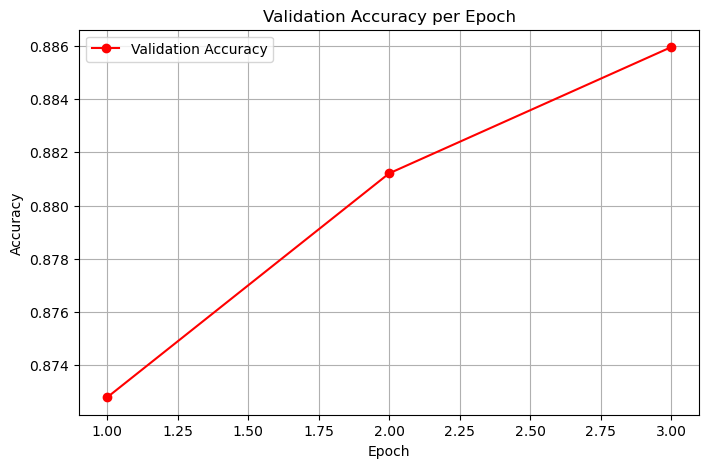

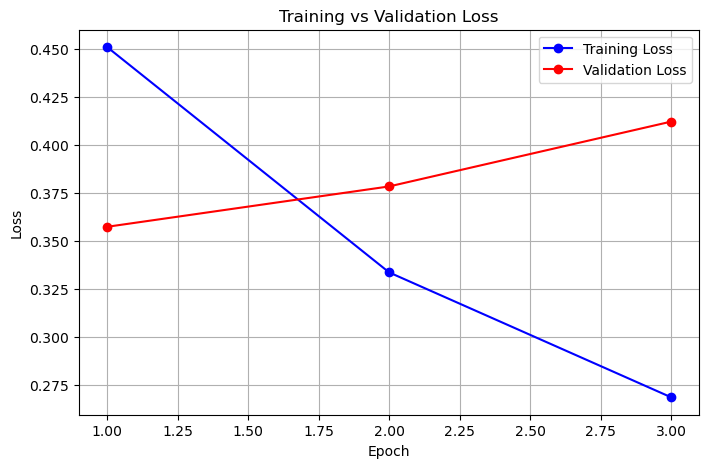

In [25]:
import matplotlib.pyplot as plt

# Extract from logs
logs = trainer.state.log_history

val_acc = [x['eval_accuracy'] for x in logs if 'eval_accuracy' in x]
train_loss = [x['loss'] for x in logs if 'loss' in x]
val_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]

epochs = range(1, len(val_acc) + 1)

# ---- Plot Validation Accuracy ----
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot Loss ----
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss[:len(epochs)], 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Key observations

* The validation accuracy shows a steady upward trend from approximately 87.3% in the first epoch to 88.6% by the third epoch, indicating consistent improvement in the model’s predictive performance over time, showing good generalization.
----

**Training vs. Validation Loss:**

The training loss decreases notably from about 0.45 to 0.27, suggesting effective learning on the training data. However, the validation loss increases gradually from 0.36 to 0.41, implying that while the model continues to fit the  training data better, its generalization performance on unseen data begins to slightly deteriorate.

### 4.2.12 Evaluate on the test data

In [26]:
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

Test Results: {'eval_loss': 0.4283587336540222, 'eval_accuracy': 0.8832131410256411, 'eval_runtime': 3664.8993, 'eval_samples_per_second': 4.086, 'eval_steps_per_second': 0.511, 'epoch': 3.0}


### 4.2.13 Saving the model

In this section we will make use of joblib and pickle to save the roberta model.

In [21]:
# Save the roberta model and tokenizer as before
model.save_pretrained("./saved_roberta_model")
tokenizer.save_pretrained("./saved_roberta_model")

# Save the model object using joblib
joblib.dump(model, "roberta_model_joblib.pkl")

# Save the model object using pickle
with open("roberta_model_pickle.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the tokenizer separately (it’s smaller)
joblib.dump(tokenizer, "roberta_tokenizer_joblib.pkl")

print("Model and tokenizer saved successfully using both joblib and pickle!")

Model and tokenizer saved successfully using both joblib and pickle!


**This code below calls in the saved model and readies it for use without having to run the whole kernel again.**

In [40]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch

In [41]:
# Load the model and tokenizer from the folder
model_path = "./saved_roberta_model"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)

# Set model to evaluation mode
model.eval()

# Example: Predict a text 
text = "i feel like killing myself  "

# Tokenize (convert text into model format)
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Get prediction
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

print("Predicted label:", predictions.item())

Predicted label: 6


The final step is to deploy this model